<a href="https://colab.research.google.com/github/cinnaavox/TravelTide-Project/blob/main/TravelTide_%E2%80%93_Week_3_Dashboard_Perk_Segmentation_(Executive_View).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dashboard TravelTide

✔ Lade user_base_week3_extended.csv aus: ./user_base_week3_extended.csv
✔ Lade perk_summary_week3.csv aus: ./perk_summary_week3.csv
✔ Lade perk_texts_week3.md aus: ./perk_texts_week3.md
✔ Lade user_perks_week3.csv aus: ./user_perks_week3.csv


/tmp/ipython-input-1702862435.py:241: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, vert=True, showfliers=False, patch_artist=True)
/tmp/ipython-input-1702862435.py:241: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, vert=True, showfliers=False, patch_artist=True)
/tmp/ipython-input-1702862435.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


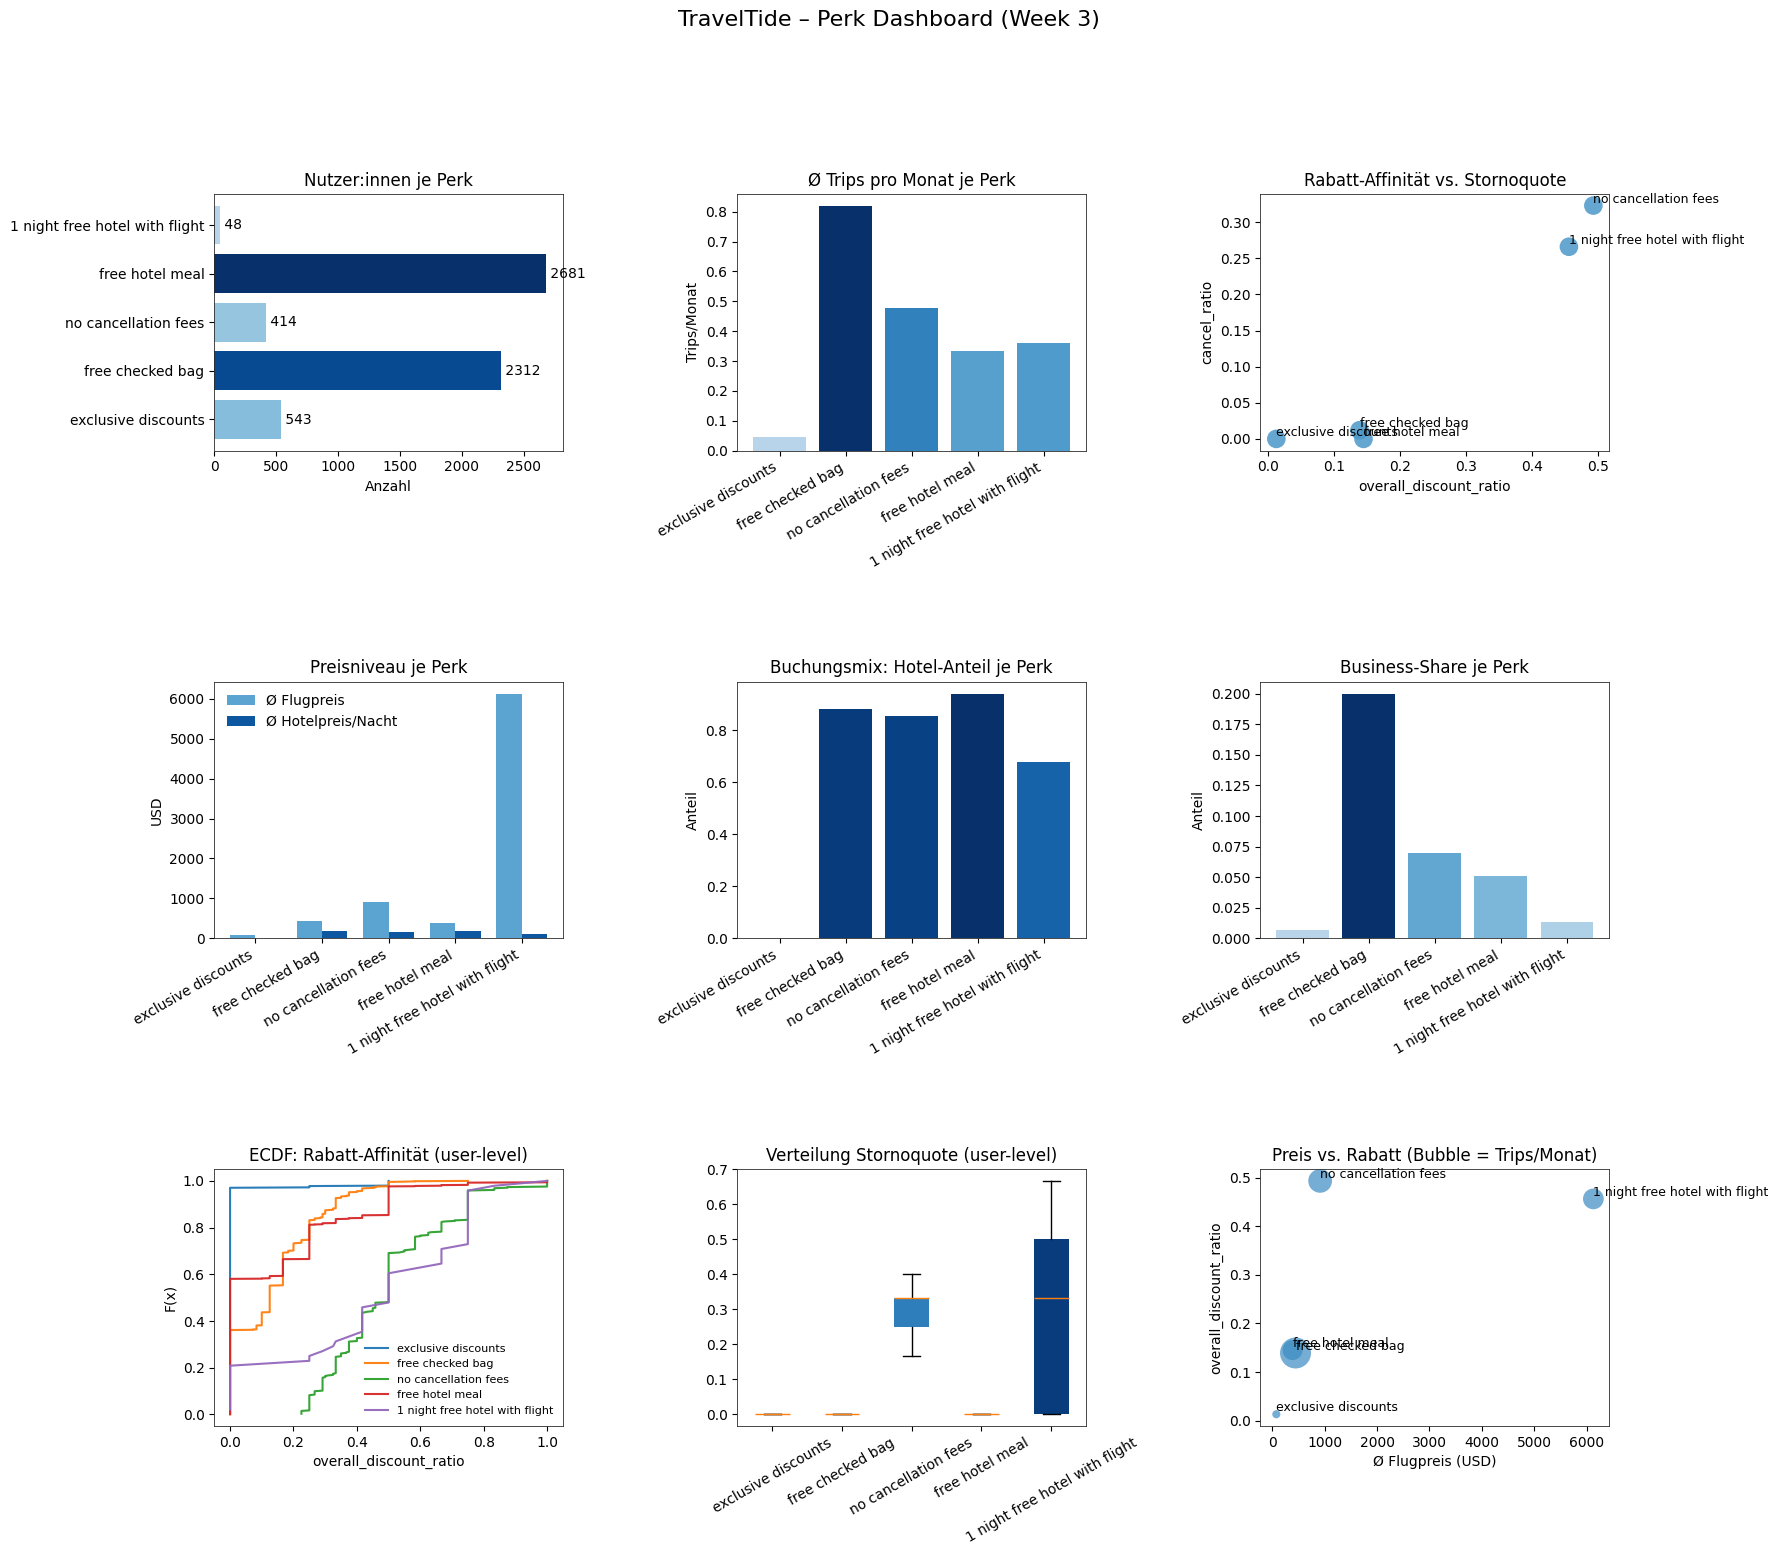


Exportierte Dateien in: /content/week3_dashboard_exports
 • 00_dashboard_full.png
 • 01_users_per_perk.png
 • 02_trips_per_month_perk.png
 • 03_discount_vs_cancel.png
 • 04_price_levels_perk.png
 • 05_hotel_share_perk.png
 • 06_business_share_perk.png
 • 07_ecdf_discount.png
 • 08_box_cancel.png
 • 09_bubble_price_discount.png


In [6]:
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Pfade & Dateien
FILES = {
    "user_base": "user_base_week3_extended.csv",
    "perk_summary": "perk_summary_week3.csv",
    "perk_texts": "perk_texts_week3.md",
    "fallback_perks": "user_perks_week3.csv",
}
CANDIDATE_DIRS = [".", "/content", "/content/drive/MyDrive", "/mnt/data"]

EXPORT_DIR = "week3_dashboard_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Loader
def _find_first(filename):
    for d in CANDIDATE_DIRS:
        p = os.path.join(d, filename)
        if os.path.exists(p):
            return p
    return None

def load_csv_or_fail(key):
    path = _find_first(FILES[key])
    if path:
        print(f"✔ Lade {FILES[key]} aus: {path}")
        return pd.read_csv(path)
    raise FileNotFoundError(f"{FILES[key]} nicht gefunden (gesucht in {', '.join(CANDIDATE_DIRS)})")

def load_csv_optional(key):
    path = _find_first(FILES[key])
    if path:
        print(f"✔ Lade {FILES[key]} aus: {path}")
        return pd.read_csv(path)
    print(f"ℹ️  {FILES[key]} nicht gefunden – überspringe.")
    return None

def load_text_optional(key):
    path = _find_first(FILES[key])
    if path:
        print(f"✔ Lade {FILES[key]} aus: {path}")
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    print(f"ℹ️  {FILES[key]} nicht gefunden – überspringe.")
    return ""

# Daten laden
user_base    = load_csv_or_fail("user_base")
perk_summary = load_csv_or_fail("perk_summary")
perk_texts   = load_text_optional("perk_texts")
fallback_perks = load_csv_optional("fallback_perks")

# df_perks (user_id + assigned_perk) herstellen
if "assigned_perk" in user_base.columns:
    df_perks = user_base[["user_id", "assigned_perk"]].dropna().copy()
elif fallback_perks is not None and {"user_id","assigned_perk"}.issubset(fallback_perks.columns):
    df_perks = fallback_perks[["user_id","assigned_perk"]].dropna().copy()
else:
    raise ValueError("Keine Spalte 'assigned_perk' gefunden (weder in user_base_week3_extended.csv noch in user_perks_week3.csv).")

# Perk-Reihenfolge & Hilfen
perk_order = [
    "exclusive discounts",
    "free checked bag",
    "no cancellation fees",
    "free hotel meal",
    "1 night free hotel with flight",
]

def align_perk_index(df, index_col=None):
    """Reindex auf perk_order; fehlende Perks -> 0/NaN sinnvoll auffüllen."""
    if index_col and index_col in df.columns:
        df = df.set_index(index_col)

    df = df.reindex(perk_order)
    return df

# Pastell-Blau Palette (hell → dunkel)
BLUES = mpl.colormaps["Blues"]

def scaled_blues(values):
    """Liste von Farben, dunkler = größerer Wert (robust gegen konstante Reihen)."""
    vals = np.array(values, dtype=float)
    if len(vals) == 0:
        return []
    vmax = np.nanmax(vals)
    vmin = np.nanmin(vals)
    # Falls alles gleich: setze mittleres Blau
    if np.isfinite(vmax) and np.isfinite(vmin) and abs(vmax - vmin) > 1e-12:
        normed = (vals - vmin) / (vmax - vmin)  # 0..1
    else:
        normed = np.full_like(vals, 0.6, dtype=float)
    # map in 0.3..1.0
    return [BLUES(0.3 + 0.7 * x) for x in normed]

def save_single_plot(draw_func, filename, figsize=(7,5), tight=True):
    """Hilfsfunktion: Einzelplot zeichnen & speichern."""
    fig, ax = plt.subplots(figsize=figsize)
    draw_func(ax)
    if tight:
        plt.tight_layout()
    out = os.path.join(EXPORT_DIR, filename)
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.close(fig)
    return out

# Perk-Level Tabelle vorbereiten
ps = align_perk_index(perk_summary, index_col="assigned_perk")

# User-Level für Verteilungen bauen (wenn vorhanden)
need_cols = ["user_id","u_trips_per_month","overall_discount_ratio","cancel_ratio",
             "avg_flight_price","avg_hotel_price_per_night"]
df_user = None
if "user_id" in user_base.columns:
    cols = [c for c in need_cols if c in user_base.columns]
    df_user = user_base[cols].merge(df_perks, on="user_id", how="inner")
    df_user = df_user[df_user["assigned_perk"].isin(perk_order)]
else:
    print("ℹ️  'user_id' in user_base nicht gefunden – user-level Verteilungen werden ggf. übersprungen.")

# Basis-Counts
perk_counts = df_perks["assigned_perk"].value_counts().reindex(perk_order, fill_value=0)

# Zeichner (jede Kachel als Funktion)
def draw_users_per_perk(ax):
    vals = perk_counts.values
    colors = scaled_blues(vals)
    ax.barh(perk_counts.index, vals, color=colors)
    ax.set_title("Nutzer:innen je Perk")
    ax.set_xlabel("Anzahl")
    ax.grid(False)
    for y, v in enumerate(vals):
        ax.text(v, y, f" {int(v)}", va="center")

def draw_trips_per_month(ax):
    if "u_trips_per_month" not in ps.columns:
        ax.axis("off"); ax.set_title("Ø Trips/Monat je Perk (keine Daten)")
        return
    vals = ps["u_trips_per_month"].fillna(0).values
    labels = ps.index.tolist()
    colors = scaled_blues(vals)
    ax.bar(range(len(vals)), vals, color=colors)
    ax.set_xticks(range(len(vals))); ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_title("Ø Trips pro Monat je Perk")
    ax.set_ylabel("Trips/Monat")
    ax.grid(False)

def draw_discount_vs_cancel(ax):
    need = {"overall_discount_ratio","cancel_ratio"}
    if not need.issubset(ps.columns):
        ax.axis("off"); ax.set_title("Rabatt vs. Storno (keine Daten)")
        return
    x = ps["overall_discount_ratio"].values
    y = ps["cancel_ratio"].values
    ax.scatter(x, y, s=180, alpha=0.85, color=BLUES(0.6), edgecolor="none")
    for xi, yi, lab in zip(x, y, ps.index):
        ax.text(xi, yi, lab, fontsize=9, ha="left", va="bottom")
    ax.set_xlabel("overall_discount_ratio")
    ax.set_ylabel("cancel_ratio")
    ax.set_title("Rabatt-Affinität vs. Stornoquote")
    ax.grid(False)

def draw_price_levels(ax):
    has_f = "avg_flight_price" in ps.columns
    has_h = "avg_hotel_price_per_night" in ps.columns
    if not (has_f or has_h):
        ax.axis("off"); ax.set_title("Preisniveau je Perk (keine Daten)")
        return
    idx = np.arange(len(ps.index))
    width = 0.38
    if has_f:
        ax.bar(idx - width/2, ps["avg_flight_price"].values, width, label="Ø Flugpreis", color=BLUES(0.55))
    if has_h:
        ax.bar(idx + width/2, ps["avg_hotel_price_per_night"].values, width, label="Ø Hotelpreis/Nacht", color=BLUES(0.85))
    ax.set_xticks(idx); ax.set_xticklabels(ps.index, rotation=30, ha="right")
    ax.set_title("Preisniveau je Perk"); ax.set_ylabel("USD")
    ax.legend(frameon=False)
    ax.grid(False)

def draw_hotel_share(ax):
    if "hotel_ratio" not in ps.columns:
        ax.axis("off"); ax.set_title("Hotel-Anteil je Perk (keine Daten)")
        return
    vals = ps["hotel_ratio"].fillna(0).values
    labels = ps.index.tolist()
    colors = scaled_blues(vals)
    ax.bar(range(len(vals)), vals, color=colors)
    ax.set_xticks(range(len(vals))); ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_title("Buchungsmix: Hotel-Anteil je Perk")
    ax.set_ylabel("Anteil")
    ax.grid(False)

def draw_business_share(ax):
    if "business_trip_share" not in ps.columns:
        ax.axis("off"); ax.set_title("Business-Share je Perk (keine Daten)")
        return
    vals = ps["business_trip_share"].fillna(0).values
    labels = ps.index.tolist()
    colors = scaled_blues(vals)
    ax.bar(range(len(vals)), vals, color=colors)
    ax.set_xticks(range(len(vals))); ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_title("Business-Share je Perk")
    ax.set_ylabel("Anteil")
    ax.grid(False)

def draw_ecdf_discount(ax):
    if df_user is None or "overall_discount_ratio" not in df_user.columns:
        ax.axis("off"); ax.set_title("ECDF Rabatt (keine User-Level Daten)")
        return
    for p in perk_order:
        d = df_user.loc[df_user["assigned_perk"]==p, "overall_discount_ratio"].dropna().values
        if len(d) == 0:
            continue
        x = np.sort(d)
        y = np.arange(1, len(x)+1)/len(x)
        ax.plot(x, y, label=p, alpha=0.95)
    ax.set_title("ECDF: Rabatt-Affinität (user-level)")
    ax.set_xlabel("overall_discount_ratio"); ax.set_ylabel("F(x)")
    ax.legend(fontsize=8, ncols=1, loc="lower right", frameon=False)
    ax.grid(False)

def draw_box_cancel(ax):
    if df_user is None or "cancel_ratio" not in df_user.columns:
        ax.axis("off"); ax.set_title("Stornoquote (keine User-Level Daten)")
        return
    data = [df_user.loc[df_user["assigned_perk"]==p, "cancel_ratio"].dropna().values for p in perk_order]
    labels = [p for p,d in zip(perk_order, data) if len(d)>0]
    data   = [d for d in data if len(d)>0]
    if not data:
        ax.axis("off"); ax.set_title("Stornoquote (keine Daten)")
        return
    bp = ax.boxplot(data, labels=labels, vert=True, showfliers=False, patch_artist=True)
    # Pastell-Blau Fills
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(BLUES(0.45 + 0.5*i/max(1,len(data)-1)))
        patch.set_edgecolor("none")
    ax.set_title("Verteilung Stornoquote (user-level)")
    ax.tick_params(axis='x', rotation=30)
    ax.grid(False)

def draw_bubble_price_discount(ax):
    need = {"avg_flight_price","overall_discount_ratio","u_trips_per_month"}
    if not need.issubset(ps.columns):
        ax.axis("off"); ax.set_title("Preis vs. Rabatt (keine Daten)")
        return
    xx = ps["avg_flight_price"].values
    yy = ps["overall_discount_ratio"].values
    ss = (ps["u_trips_per_month"].values + 0.01) * 600
    ax.scatter(xx, yy, s=ss, alpha=0.7, color=BLUES(0.65), edgecolor="none")
    for xi, yi, li in zip(xx, yy, ps.index):
        ax.text(xi, yi, li, fontsize=9, ha="left", va="bottom")
    ax.set_xlabel("Ø Flugpreis (USD)"); ax.set_ylabel("overall_discount_ratio")
    ax.set_title("Preis vs. Rabatt (Bubble = Trips/Monat)")
    ax.grid(False)

# Einzel-PNGs speichern
exports = []
exports.append(save_single_plot(draw_users_per_perk,       "01_users_per_perk.png"))
exports.append(save_single_plot(draw_trips_per_month,      "02_trips_per_month_perk.png"))
exports.append(save_single_plot(draw_discount_vs_cancel,   "03_discount_vs_cancel.png"))
exports.append(save_single_plot(draw_price_levels,         "04_price_levels_perk.png"))
exports.append(save_single_plot(draw_hotel_share,          "05_hotel_share_perk.png"))
exports.append(save_single_plot(draw_business_share,       "06_business_share_perk.png"))
exports.append(save_single_plot(draw_ecdf_discount,        "07_ecdf_discount.png"))
exports.append(save_single_plot(draw_box_cancel,           "08_box_cancel.png"))
exports.append(save_single_plot(draw_bubble_price_discount,"09_bubble_price_discount.png"))

# Gesamtdashboard (3x3)
plt.close("all")
fig = plt.figure(figsize=(18, 16), constrained_layout=False)
gs  = GridSpec(nrows=3, ncols=3, figure=fig, hspace=0.9, wspace=0.5)

axes = []
axes.append(fig.add_subplot(gs[0,0])); draw_users_per_perk(axes[-1])
axes.append(fig.add_subplot(gs[0,1])); draw_trips_per_month(axes[-1])
axes.append(fig.add_subplot(gs[0,2])); draw_discount_vs_cancel(axes[-1])
axes.append(fig.add_subplot(gs[1,0])); draw_price_levels(axes[-1])
axes.append(fig.add_subplot(gs[1,1])); draw_hotel_share(axes[-1])
axes.append(fig.add_subplot(gs[1,2])); draw_business_share(axes[-1])
axes.append(fig.add_subplot(gs[2,0])); draw_ecdf_discount(axes[-1])
axes.append(fig.add_subplot(gs[2,1])); draw_box_cancel(axes[-1])
axes.append(fig.add_subplot(gs[2,2])); draw_bubble_price_discount(axes[-1])

fig.suptitle("TravelTide – Perk Dashboard (Week 3)", fontsize=16, y=0.995)
plt.tight_layout()
full_path = os.path.join(EXPORT_DIR, "00_dashboard_full.png")
fig.savefig(full_path, dpi=150, bbox_inches="tight")
plt.show()

print("\nExportierte Dateien in:", os.path.abspath(EXPORT_DIR))
for f in sorted(os.listdir(EXPORT_DIR)):
    print(" •", f)
